In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('bmh')
import seaborn as sns
%matplotlib inline

from itertools import product

import numpy as np
import scipy as sp

from sklearn.decomposition import PCA

import torch

import sys
import os
import shutil
import pickle as pkl
import glob
import collections
from tqdm import tqdm

from omegaconf import OmegaConf

sys.path.append('..')
# sys.path.append('../planning')

import cartpole_emb
import util
# from cartpole_emb import 
# from env_dx.cartpole import CartpoleDx
from dcem import dcem

In [2]:
plot_dir = '../cartpole_emb/2019.09.09/plots'
if os.path.exists(plot_dir):
    shutil.rmtree(plot_dir)
os.makedirs(plot_dir)

In [3]:
try:
    full_cost
except:
    exp_dir = '../cartpole_emb/2019.09.09/dcem.params.ctrl_opts.temp=1,dcem.params.latent_size=2,seed=0'
    exp = pkl.load(open(exp_dir+'/latest.pkl', 'rb'))
    full_cost = exp.solve_full(exp.xinit_val)['cost'].mean()
    full_cost

In [4]:
exps = sorted(glob.glob('../cartpole_emb/2019.09.09-v5/*'))

best_vals = []
dfs = []

for exp_path in exps:
    fname = f'{exp_path}/config.yaml'
    if not os.path.exists(fname):
        continue

    cfg = OmegaConf.load(fname)
#     exp = pkl.load(open(exp_path+'/latest.pkl', 'rb'))
    temp, latent_sz, seed = cfg.dcem.params.ctrl_opts.temp, cfg.dcem.params.latent_size, cfg.seed
    n_iter = cfg.dcem.params.ctrl_opts.n_iter
    fname = f'{exp_path}/losses.csv'
    if not os.path.exists(fname):
        continue
    df = pd.read_csv(fname)
    
    I = df['mode'] == 'train'
    N = 100
    x, y = util.smooth(df[I].iter.values, df[I].loss.values, N=N)
    if df.iloc[-1].iter >= cfg.n_train_iter-100:
        _x = np.linspace(x.min(), x.max(), num=200)
        _x = np.logspace(np.log10(x.min()), np.log10(x.max()), base=10., num=200)
        _x[_x > x.max()] = x.max()
        _y = sp.interpolate.interp1d(x, y)(_x)
        x, y = _x, _y
    else:
        print('skipping ', fname)
        continue
    df.drop(df[I].index, inplace=True)
    df = df.append(pd.DataFrame({'iter': x, 'loss': y, 'mode': 'smooth_train'}))
        
    I = df['mode'] == 'val'
    x = df[I].iter.values + 1
    y = df[I].loss.values
#     _x = np.linspace(x.min(), x.max(), num=200)
    _x = np.logspace(np.log10(x.min()), np.log10(x.max()), base=10., num=200)
    _x[_x > x.max()] = x.max()
    _y = sp.interpolate.interp1d(x, y)(_x)
    df = df.append(pd.DataFrame({'iter': _x, 'loss': _y, 'mode': 'interp_val'}))
    
    min_val = df['loss'][df['mode'] == 'val'].min()
    if temp is None:
        temp = np.infty
    df['temp'] = temp
    df['temp_str'] = str(temp)
    df['latent_sz'] = latent_sz
    df['n_iter'] = n_iter
    df['seed'] = seed
    df['key'] = f'({temp}, {latent_sz}, {n_iter})'
    dfs.append(df)
    best_vals.append({
        'exp_path': exp_path, 'temp': temp, 'latent_sz': latent_sz,
        'n_iter': n_iter,
        'seed': seed, 'best_val': min_val
    })
    
best_vals = pd.DataFrame(best_vals)
dfs = pd.concat(dfs, keys=exps, names=['Exp ID'])

In [5]:
best_vals[best_vals['latent_sz'] == 2]

,best_val,exp_path,latent_sz,n_iter,seed,temp
3,-9.905835,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,0,1.0
4,-9.765819,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,1,1.0
5,-9.713945,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,2,1.0
12,-9.732860,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,0,10.0
13,-9.372995,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,1,10.0
14,-9.320761,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,2,10.0
21,-9.829904,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,0,inf
22,-9.375441,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,1,inf
23,-10.312959,../cartpole_emb/2019.09.09-v5/dcem.params.ctrl...,2,10,2,inf


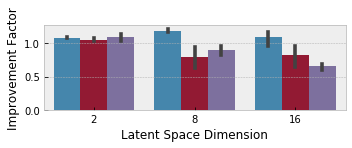

In [6]:
# best_vals.groupby(['latent_sz', 'temp']).best_val.agg(['mean', 'std'])
best_vals['improvement'] = best_vals.best_val/util.to_np(full_cost)

fig, ax = plt.subplots(1, 1, figsize=(5,2))
sns.barplot(x='latent_sz', hue='temp', y='improvement', data=best_vals, ax=ax, ci=95)
ax.set_xlabel('Latent Space Dimension')
ax.set_ylabel('Improvement Factor')
ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(f'{plot_dir}/improvement-factor-main.pdf')

In [7]:
try:
    u_nominal
except:
    exp_dir = '../cartpole_emb/2019.09.09/dcem.params.ctrl_opts.temp=1,dcem.params.latent_size=2,seed=0'
    exp = pkl.load(open(exp_dir+'/latest.pkl', 'rb'))
    # full_cost = exp.solve_full(exp.xinit_val)['cost'].mean()
    # full_cost

    n_train = 10000
    n_batch = 100
    torch.manual_seed(1) # Val dataset created with seed=0
    u_nominal = []
    for i in tqdm(range(n_train//n_batch)):
        u_nominal.append(exp.solve_full(cartpole_emb.sample_init(n_batch=n_batch))['u_nominal'].squeeze())

    u_nominal = torch.cat(u_nominal, dim=1).t()

100%|██████████| 100/100 [04:26<00:00,  2.41s/it]


In [8]:
try:
    pca_val
except:
    exp_dir = '../cartpole_emb/2019.09.09/dcem.params.ctrl_opts.temp=1,dcem.params.latent_size=2,seed=0'
    exp = pkl.load(open(exp_dir+'/latest.pkl', 'rb'))
    n_val = exp.xinit_val.size(0)

    n_latent = 2
    pca = PCA(n_components=n_latent)
    pca.fit(util.to_np(u_nominal))
    xinit = cartpole_emb.sample_init()
    def get_cost_pca(xinit):
        def f_emb_pca(z):
            u = torch.from_numpy(pca.inverse_transform(z)).t().unsqueeze(2).float()
            nbatch = u.shape[1]
            xinit_sample = xinit.repeat(nbatch, 1)
            cost = -cartpole_emb.rew_nominal(exp.dx, xinit_sample, u)[0]
            return cost
        return f_emb_pca

    costs = []
    for i in range(n_val):
        xinit = exp.xinit_val[i].cpu()
        lb, ub = -200., 200.
        N = 200
        x = np.linspace(lb, ub, N)
        y = np.linspace(lb, ub, N)
        X, Y = np.meshgrid(x, y)
        Xflat = X.reshape(-1)
        Yflat = Y.reshape(-1)
        XYflat = np.stack((Xflat, Yflat), axis=1)
        if i == 0:
            print(f'Grid-searching with {XYflat.shape[0]} points')
        costs.append(get_cost_pca(xinit)(XYflat).min().item())

    pca_val = np.mean(costs)
    print(f'PCA val = {pca_val}')
    print(f'PCA improvement factor = {pca_val/util.to_np(full_cost)}')

Grid-searching with 40000 points
PCA val = -9.656941756010056
PCA improvement factor = 1.0675127486180158


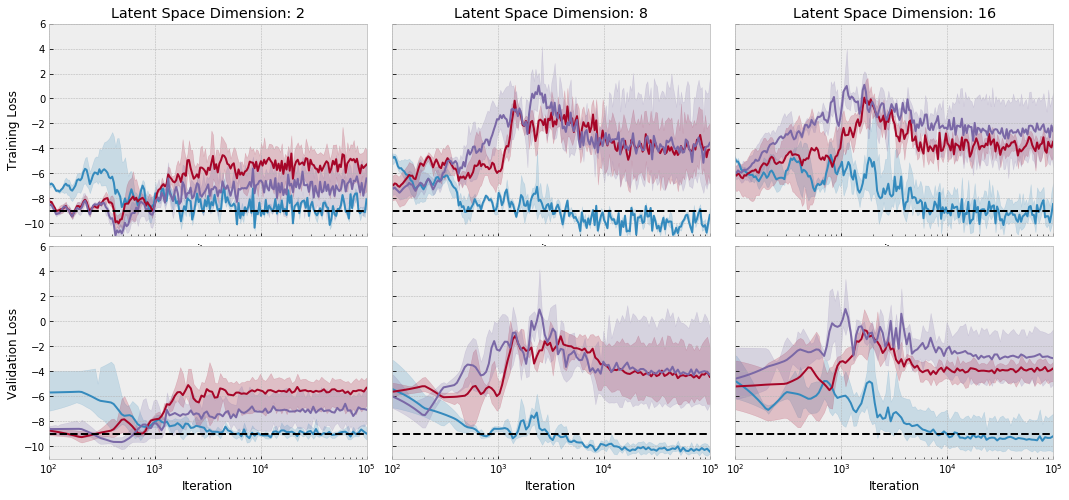

In [9]:
n_col = 3
n_row = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(6*n_col, 4*n_row), gridspec_kw={'wspace': 0.08, 'hspace': 0.05})
axs = axs.ravel()

ci = 95
for i, latent_sz in enumerate([2, 8, 16]):
    I = (dfs['mode'] == 'smooth_train') & (dfs['latent_sz'] == latent_sz)
    _dfs = dfs[I]
    ax = axs[i]
    sns.lineplot(x='iter', y='loss', data=_dfs, ci=ci, hue='key', ax=ax, legend=False)
#     ax.axhline(full_cost, linestyle='--', color='k')
    ax.set_ylim(-11., 6.)
    ax.set_xlim(1e2, 1e5)
    ax.set_xscale('log')
    if i > 0:
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Training Loss')
    ax.get_xaxis().set_ticklabels([])
    ax.set_title(f'Latent Space Dimension: {latent_sz}')
    ax.axhline(full_cost, linestyle='--', color='k')

for i, latent_sz in enumerate([2, 8, 16], start=3):
    I = (dfs['mode'] == 'interp_val') & (dfs['latent_sz'] == latent_sz)
    _dfs = dfs[I]
    ax = axs[i]
    sns.lineplot(x='iter', y='loss', data=_dfs, ci=ci, hue='key', ax=ax, legend=False)
    ax.axhline(full_cost, linestyle='--', color='k')
    ax.set_ylim(-11., 6.)
    ax.set_xlim(1e2, 1e5)
    ax.set_xscale('log')
    ax.set_xlabel('Iteration')
    if i > 3:
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Validation Loss')
        
fig.savefig(f'{plot_dir}/all-convergence.pdf')

In [10]:
def plot_contour(
    f_emb, f_emb_torch=True, ax=None,
    cem_opt=None, lb=-5., ub=5., N=100,
    xlabel='Latent Dim 1', ylabel='Latent Dim 2',
    colorbar=True, show_best_text=True,
    vmin=None, vmax=None,
):
    x = np.linspace(lb, ub, N)
    y = np.linspace(lb, ub, N)
    X, Y = np.meshgrid(x, y)
    Xflat = X.reshape(-1)
    Yflat = Y.reshape(-1)
    XYflat = np.stack((Xflat, Yflat), axis=1)
    if f_emb_torch:
        Zflat = f_emb(torch.from_numpy(XYflat).float().cuda()).detach().cpu().numpy()
    else:
        Zflat = f_emb(XYflat)
    Z = Zflat.reshape(X.shape)
    if vmin is not None:
        Z[Z < vmin] = vmin
    if vmax is not None:
        Z[Z > vmax] = vmax

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
 
    CS = ax.contourf(X, Y, Z, cmap=cm.Blues)
    if colorbar:
        fig.colorbar(CS, ax=ax)
    
    if cem_opt is not None:
        cem_val = f_emb(cem_opt.unsqueeze(0)).item()
        cem_opt = cem_opt.detach().numpy()
        rcolor = (0.73, 0.22, 0.15)
        ax.scatter(*cem_opt, marker='*', s=200, color=rcolor)
        ax.text(
            0.0, 1.04, f'\u2605 CEM (Rew: {-cem_val:.2f})', fontsize=10,
            color=rcolor, ha='left', va='center',
            transform=ax.transAxes
        )
    
    i = np.argmin(Zflat)
    zi = Zflat[i]
    xi = Xflat[i]
    yi = Yflat[i]
    ax.scatter(xi, yi, marker='*', s=200, color='k')
    if show_best_text:
        ax.text(
            0., 0., f'\u2605 Best Cost: {zi:.2f}', fontsize=10,
            color='k', ha='left', va='bottom',
            transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0', facecolor='white', alpha=0.8)
        )
        
    ax.set_xlim(lb, ub)
    ax.set_ylim(lb, ub)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    return fig, ax, zi

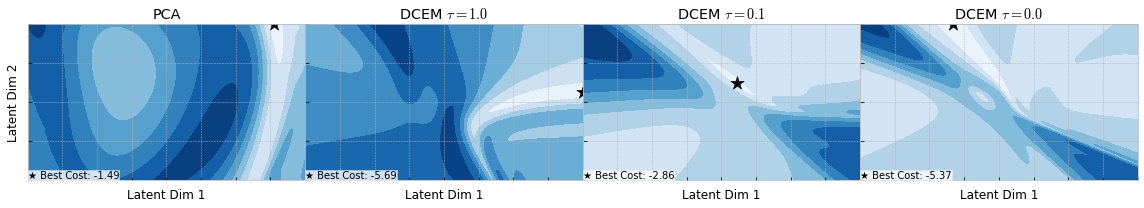

In [11]:
n_col = 4
n_row = 1
fig, axs = plt.subplots(n_row, n_col, figsize=(4*n_col, 3*n_row), gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.ravel()

torch.manual_seed(15)
xinit = cartpole_emb.sample_init()

ax = axs[0]
b = 200.
plot_contour(f_emb=get_cost_pca(xinit), f_emb_torch=False, N=500, lb=-b, ub=b, ax=ax, colorbar=False)
ax.set_title(f'PCA')

exp_roots = [
    '../cartpole_emb/2019.09.09-v5/dcem.params.ctrl_opts.temp=1,dcem.params.latent_size=2,seed=0',
    '../cartpole_emb/2019.09.09-v5/dcem.params.ctrl_opts.temp=10,dcem.params.latent_size=2,seed=0',
    '../cartpole_emb/2019.09.09-v5/dcem.params.ctrl_opts.temp=null,dcem.params.latent_size=2,seed=0',
]
temps = [1., 0.1, 0.0]

b = 1.
for i, (temp, exp_root) in enumerate(zip(temps, exp_roots), start=1):
    exp = pkl.load(open(exp_root+'/best.pkl', 'rb'))
    ax = axs[i]
    plot_contour(f_emb=exp.method.get_cost_f(xinit.cuda()), N=500,
                 lb=-b, ub=b, ax=ax, ylabel=None, colorbar=False)
    ax.set_title(f'DCEM $\\tau={temp:.1f}$')
    
for ax in axs:
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

fig.tight_layout()
fig.savefig(f'{plot_dir}/surface-vis-best-main-paper.pdf')

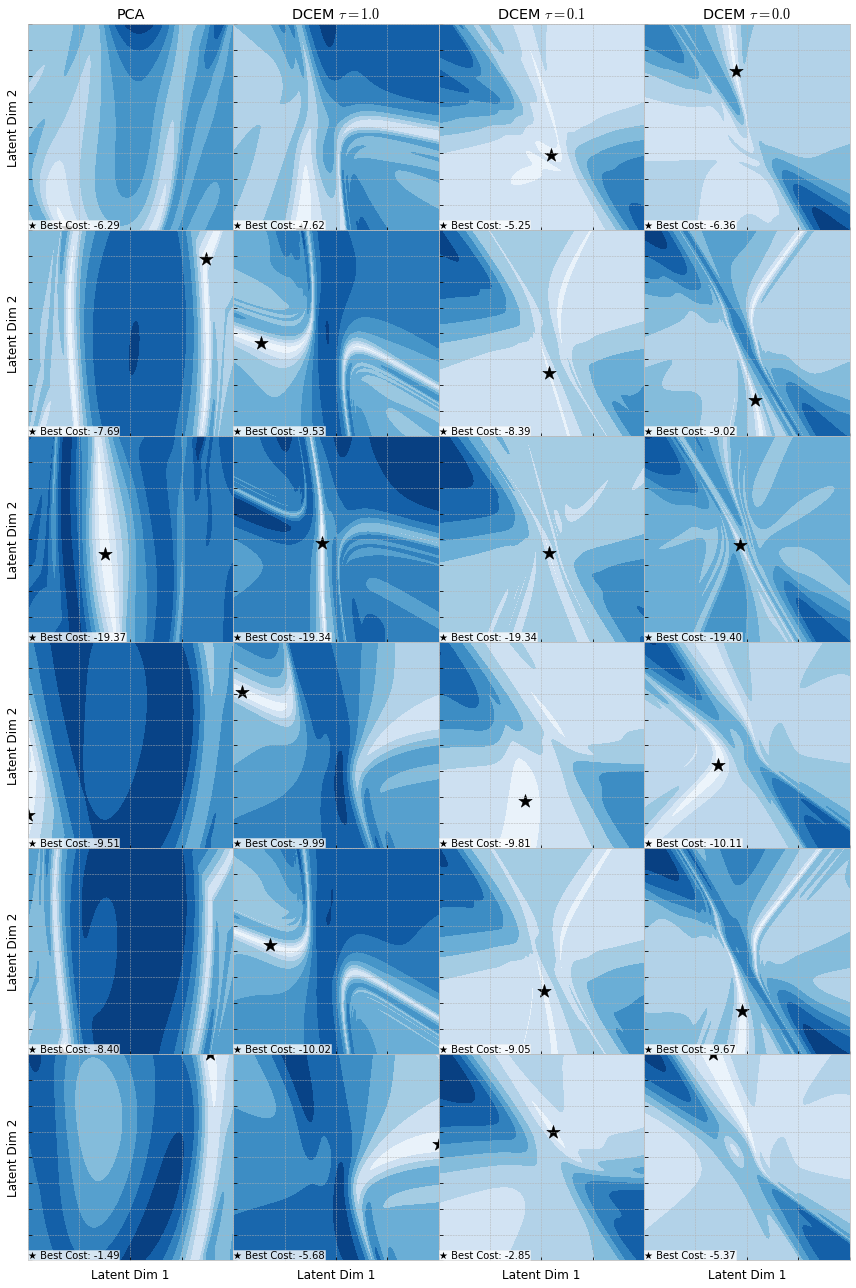

In [12]:
n_col = 4
n_row = 6
fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col, 3*n_row), gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.ravel()
ax_i = 0

for i in range(n_row):
    torch.manual_seed(10+i)
    xinit = cartpole_emb.sample_init()

    ax = axs[ax_i]
    b = 200.
    _, _, best = plot_contour(f_emb=get_cost_pca(xinit), f_emb_torch=False, N=300, lb=-b, ub=b, ax=ax, colorbar=False)
    # ax.set_title(f'PCA (Best Cost = {best:.2f})')
    if ax_i == 0:
        ax.set_title(f'PCA')
    ax_i += 1

    temps = [1., 0.1, 0.]

    b = 1.
    for temp, exp_root in zip(temps, exp_roots):
        exp = pkl.load(open(exp_root+'/best.pkl', 'rb'))
        ax = axs[ax_i]
        _, _, best = plot_contour(f_emb=exp.method.get_cost_f(xinit.cuda()), N=300,
                                  lb=-b, ub=b, ax=ax, ylabel=None, colorbar=False)
    #     ax.set_title(f'DCEM $\\tau={temp}$ (Best Cost = {best:.2f})')
        if ax_i < 4:
            ax.set_title(f'DCEM $\\tau={temp:.1f}$')
        ax_i += 1

for ax in axs:
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

fig.tight_layout()
fig.savefig(f'{plot_dir}/surface-vis-best-appendix.pdf')

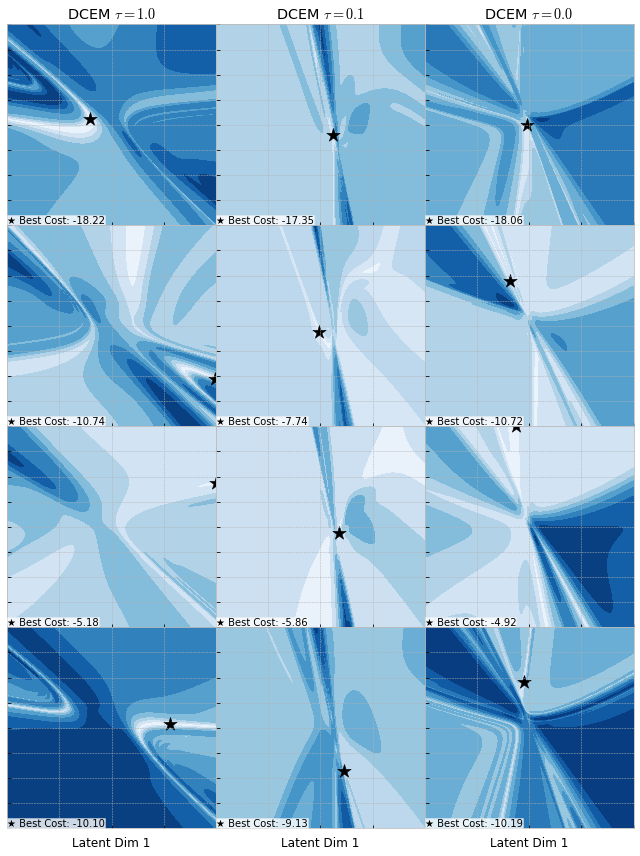

In [13]:
n_col = 3
n_row = 4
fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col, 3*n_row), gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.ravel()
ax_i = 0

for i in range(n_row):
    torch.manual_seed(i+1)
    xinit = cartpole_emb.sample_init()

#     ax = axs[ax_i]
#     b = 200.
#     _, _, best = plot_contour(f_emb=get_cost_pca(xinit), f_emb_torch=False, N=300, lb=-b, ub=b, ax=ax, colorbar=False)
#     # ax.set_title(f'PCA (Best Cost = {best:.2f})')
#     if ax_i == 0:
#         ax.set_title(f'PCA')
#     ax_i += 1

#     temps = [1, 10, '\infty']
    temps = [1, 0.1, 0.0]

    b = 1.
    for temp, exp_root in zip(temps, exp_roots):
        exp = pkl.load(open(exp_root+'/latest.pkl', 'rb'))
        ax = axs[ax_i]
        _, _, best = plot_contour(f_emb=exp.method.get_cost_f(xinit.cuda()), N=300,
                                  lb=-b, ub=b, ax=ax, ylabel=None, colorbar=False)
    #     ax.set_title(f'DCEM $\\tau={temp}$ (Best Cost = {best:.2f})')
        if ax_i < 3:
            ax.set_title(f'DCEM $\\tau={temp:.1f}$')
        ax_i += 1

for ax in axs:
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

fig.tight_layout()
fig.savefig(f'{plot_dir}/surface-vis-latest-appendix.pdf')

In [14]:
seed = 15
torch.manual_seed(seed)
xinit = cartpole_emb.sample_init()

exp_dir = exp_roots[0]
# exp_dir = '../cartpole_emb/2019.09.09-v4/dcem.params.ctrl_opts.temp=1,dcem.params.latent_size=2,seed=1'
print(exp_dir)
exp = pkl.load(open(exp_dir+'/best.pkl', 'rb'))

def f_full(u):
    u = u.transpose(0,2)
    nbatch = u.size(1)
    xinit_batch = xinit.repeat(nbatch, 1)
    rews = -cartpole_emb.rew_nominal(exp.dx, xinit_batch, u)[0]
    return rews

Xs_full = []
def iter_cb(i, X, fX, I, X_I, mu, sigma):
    Xs_full.append(X)
    assert fX.ndimension() == 2
    I = I.view(fX.shape)
    print(f'  + {i}: {(fX*I).sum()/I.sum():.2f}')
#     print(f'    + {I.min().item():.2f}/{I.max().item():.2f}')

full_out = dcem(
    f_full, exp.dx.n_ctrl*exp.cfg.plan_horizon, n_sample=1000,
    n_elite=5, n_iter=10,
    iter_cb=iter_cb,
    temp=None, lb=exp.dx.lower, ub=exp.dx.upper,
    init_mu=None, init_sigma=0.5*(exp.dx.upper-exp.dx.lower),
)
f_full(full_out.unsqueeze(0))

../cartpole_emb/2019.09.09-v5/dcem.params.ctrl_opts.temp=1,dcem.params.latent_size=2,seed=0
  + 0: 3.04
  + 1: 1.75
  + 2: 2.05
  + 3: -0.21
  + 4: -1.87
  + 5: -2.44
  + 6: -2.92
  + 7: -3.15
  + 8: -3.28
  + 9: -3.35


tensor([-3.3683], grad_fn=<NegBackward>)

In [15]:
def f_emb(z):
    u = exp.method.decode(z.view(-1, exp.method.latent_size).cuda())
    nbatch = u.size(1)
    xinit_batch = xinit.repeat(nbatch, 1).cuda()
    rews = -cartpole_emb.rew_nominal(exp.dx, xinit_batch, u)[0]
    return rews

Xs_latent = []
def iter_cb(i, X, fX, I, X_I, mu, sigma):
    Xs_latent.append(X)
    assert fX.ndimension() == 2
    I = I.view(fX.shape)
    print(f'  + {I.min():.2f}/{I.max():.2f}')
    print(f'  + {i}: {(fX*I).sum()/I.sum():.2f}')
#     print(f'    + {I.min().item():.2f}/{I.max().item():.2f}')

emb_out = dcem(
    f_emb, exp.method.latent_size, device='cuda',
    iter_cb=iter_cb,
    **exp.method.ctrl_opts
)
f_emb(emb_out.cuda())

  + 0.01/0.52
  + 0: 4.25
  + 0.01/0.32
  + 1: 1.00
  + 0.01/0.25
  + 2: -1.41
  + 0.00/0.23
  + 3: -2.72
  + 0.00/0.20
  + 4: -3.77
  + 0.00/0.18
  + 5: -4.40
  + 0.00/0.18
  + 6: -4.93
  + 0.00/0.17
  + 7: -5.13
  + 0.00/0.17
  + 8: -5.28
  + 0.00/0.20
  + 9: -5.41


tensor([-5.5543], device='cuda:0', grad_fn=<NegBackward>)

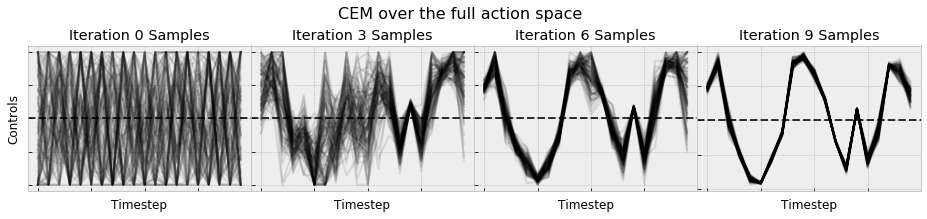

In [16]:
n_col = 4
n_row = 1
fig, axs = plt.subplots(n_row, n_col, figsize=(4*n_col, 3*n_row), gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.ravel()

for i in range(n_col):
    ax = axs[i]
    cem_i = 3*i
    ax.set_title(f'Iteration {cem_i} Samples')
    X = Xs_full[cem_i].squeeze()
    X = util.to_np(X.t())
    X = X[:,:100]
    ax.plot(X, color='k', alpha=0.1)
    ax.axhline(0., linestyle='--', color='k', alpha=0.8)
    
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    if i == 0:
        ax.set_ylabel('Controls')
    ax.set_xlabel('Timestep')
    
fig.suptitle('CEM over the full action space', fontsize=16)
fig.subplots_adjust(top=0.8)
fig.savefig(f'{plot_dir}/cem-vis-full-space.pdf')

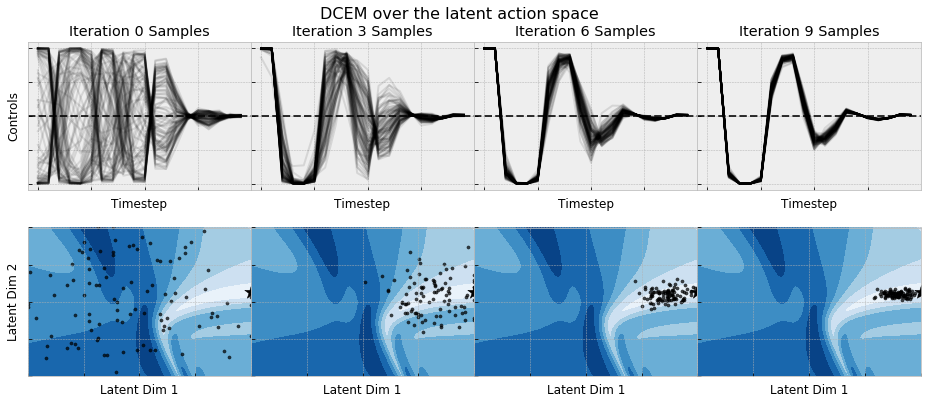

In [17]:
# def plot_contour(
#     f_emb, f_emb_torch=True, ax=None,
#     cem_opt=None, lb=-5., ub=5., N=100,
#     xlabel='Latent Dim 1', ylabel='Latent Dim 2',
#     colorbar=True,
# ):
n_col = 4
n_row = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(4*n_col, 3*n_row), gridspec_kw={'wspace': 0, 'hspace': 0.25})
axs = axs.ravel()


for i in range(n_col):
    ax = axs[i]
    cem_i = 3*i
    ax.set_title(f'Iteration {cem_i} Samples')
    X = exp.method.decode(Xs_latent[cem_i].squeeze()).squeeze()
    X = util.to_np(X)
    ax.plot(X, color='k', alpha=0.1)
    ax.axhline(0., linestyle='--', color='k', alpha=0.8)
    
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    if i == 0:
        ax.set_ylabel('Controls')
    ax.set_xlabel('Timestep')

if exp.method.latent_size == 2:
    for i in range(n_col):
        ax = axs[n_col+i]
        cem_i = 3*i
        X = Xs_latent[cem_i].squeeze()
        X = util.to_np(X)
        plot_contour(
            f_emb, f_emb_torch=True, ax=ax,
            lb=-1., ub=1., N=500, show_best_text=False, colorbar=False,
        )
        ax.scatter(*X.T, color='k', alpha=0.7, s=10)
        ax.set_xlim(-1., 1.)
        ax.set_ylim(-1., 1.)
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])
        if i > 0:
            ax.set_ylabel('')
        
fig.suptitle('DCEM over the latent action space', fontsize=16)
fig.subplots_adjust(top=0.9)
fig.savefig(f'{plot_dir}/cem-vis-latent-space.pdf')

In [18]:
assert False, 'Not updated but was a cool animation'
waypoints = [
    [-1, 0], [1, 0], [-1, 0],
    [0, -1], [0, 1], [0, -1],
    [-1, -1], [1, 1], [-1, -1],
    [1, -1], [-1, 1], [1, -1]
]
waypoints = [np.expand_dims(np.array(p), 0) for p in waypoints]
u_embs = []
last_p = waypoints[0]
for i, p in enumerate(waypoints[1:]):
    if (i+1) % 3 != 0:
        alpha = np.expand_dims(np.linspace(0, 1, num=25), 1)
        u_embs.append(torch.from_numpy((1.-alpha)*last_p + alpha*p).float())
    last_p = p

u_embs = torch.cat(u_embs)
u_emb_dec = net(u_embs)

out_dir = '../data/2019.07.22/interp'
# shutil.rmtree(out_dir)
os.makedirs(out_dir, exist_ok=True)

for i in range(u_embs.size(0)):
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    ax = axs[0]
    ax.scatter(u_embs[i,0].item(), u_embs[i,1].item(), color='k')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_title('Embedded Control Space')
    ax.set_xlabel('Latent Dim 1')
    ax.set_ylabel('Latent Dim 2')

    ax = axs[1]
    ax.plot(u_emb_dec[i].detach().numpy(), color='k')
    ax.set_title('Full Control Space')
    ax.set_ylim(-100., 100.)
    ax.set_xlabel('Nominal Timestep')
    ax.set_ylabel('Control Value')
    
    fig.tight_layout()
    fig.savefig(f'{out_dir}/{i:03d}.png')
    plt.close(fig)

os.system(f'convert -delay 10 -loop 0 {out_dir}/???.png {out_dir}/interp.gif')
os.system(f'rm {out_dir}/*.png')

AssertionError: Not updated but was a cool animation